# Prototypical Netwoks for Classification

##Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange


In [2]:
print(torch.cuda.is_available())

True


##Import data

The Omniglot dataset is taken on [the official GitHub repository](https://github.com/brendenlake/omniglot)

- Features 1623 handwritten characters from 50 ;anguages.
- Each character was drawn by 20 individuals via Amazon's Mechanical Turk.
- Includes stroke data ([x,y,t] coordinates) for each character, capturing the dynamics of handwriting.

In [3]:
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip

!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip

--2024-04-08 20:34:48--  https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip [following]
--2024-04-08 20:34:48--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6462886 (6.2M) [application/zip]
Saving to: ‘images_evaluation.zip.1’

images_evaluation.z 100%[===================>]   6.16M  --.-KB/s    in 0.09s   

2024-04-08 20:34:49 (66.5 MB/s) - ‘images_evaluation.zip.1’ save

In [4]:
!unzip -qq images_evaluation.zip
!unzip -qq images_background.zip

replace images_background/Alphabet_of_the_Magi/character01/0709_01.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace images_evaluation/Angelic/character01/0965_01.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

##Read data

In [27]:
def load_character_images(path_to_alphabet, alphabet_name):
  images_list = []
  labels_list = []
  character_folders = os.listdir(path_to_alphabet)

  for folder in character_folders:
      full_path = os.path.join(path_to_alphabet, folder)
      image_files = os.listdir(full_path)

      for file in image_files:
          img_path = os.path.join(full_path, file)
          original_image = cv2.imread(img_path)
          resized_image = cv2.resize(original_image, (28, 28))

          # generating rotated versions of the image
          rotations = [0, 90, 180, 270]
          for angle in rotations:
              if angle == 0:
                  rotated_image = resized_image
              else:
                  rotated_image = ndimage.rotate(resized_image, angle)
              images_list.append(rotated_image)
              labels_list.append(f"{alphabet_name}_{folder}_{angle}")

  return np.array(images_list), np.array(labels_list)


In [28]:
def fetch_images(root_dir):
    images, labels = None, None
    with mp.Pool(processes=mp.cpu_count()) as pool:
        fetch_results = [pool.apply(load_character_images, args=(os.path.join(root_dir, dir_name) + '/', dir_name)) for dir_name in os.listdir(root_dir)]

    for img_data, lbl_data in fetch_results:
        images = np.vstack([images, img_data]) if images is not None else img_data
        labels = np.concatenate([labels, lbl_data]) if labels is not None else lbl_data

    return images, labels


In [29]:
trainx, trainy = fetch_images('images_background')
testx, testy = fetch_images('images_evaluation')

In [31]:
print(f"Training Images Shape: {trainx.shape}")
print(f"Training Labels Shape: {trainy.shape}")
print(f"Testing Images Shape: {testx.shape}")
print(f"Testing Labels Shape: {testy.shape}")


Training Images Shape: (77120, 28, 28, 3)
Training Labels Shape: (77120,)
Testing Images Shape: (52720, 28, 28, 3)
Testing Labels Shape: (52720,)


In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0



### Training Set:
1. **Images**: 77,120, from 3,856 characters in the background set.
2. **Shape**: Images - (77120, 28, 28, 3), Labels - (77120,).

### Testing Set:
1. **Images**: 52,720, from 2,636 characters in the evaluation set.
2. **Shape**: Images - (52720, 28, 28, 3), Labels - (52720,).




##Create samples

In [33]:
def gather_samples(num_classes, support_size, query_size, image_data, label_data):
    selected_samples = []
    chosen_labels = np.random.choice(np.unique(label_data), num_classes, replace=False)

    for label in chosen_labels:
        images_of_class = image_data[label_data == label]
        shuffled_images = np.random.permutation(images_of_class)
        selected_images = shuffled_images[:support_size + query_size]
        selected_samples.append(selected_images)

    selected_samples = np.stack(selected_samples)
    tensor_samples = torch.tensor(selected_samples, dtype=torch.float).to(device)
    reshaped_samples = tensor_samples.permute(0, 1, 4, 2, 3)

    return {
        'images': reshaped_samples,
        'n_way': num_classes,
        'n_support': support_size,
        'n_query': query_size
    }


In [34]:
def display_sample(sample):
    sample_cpu = sample.cpu()
    sample_4D = sample_cpu.view(sample_cpu.shape[0] * sample_cpu.shape[1], *sample_cpu.shape[2:])
    out = torchvision.utils.make_grid(sample_4D, nrow=sample_cpu.shape[1])
    plt.figure(figsize=(16, 7))
    # Convert tensor to numpy array and display it
    plt.imshow(out.permute(1, 2, 0).numpy())
    plt.show()




As an example, let's pick a sample and display it

*   n_way = 8
*   n_support = 5
*   n_query = 5




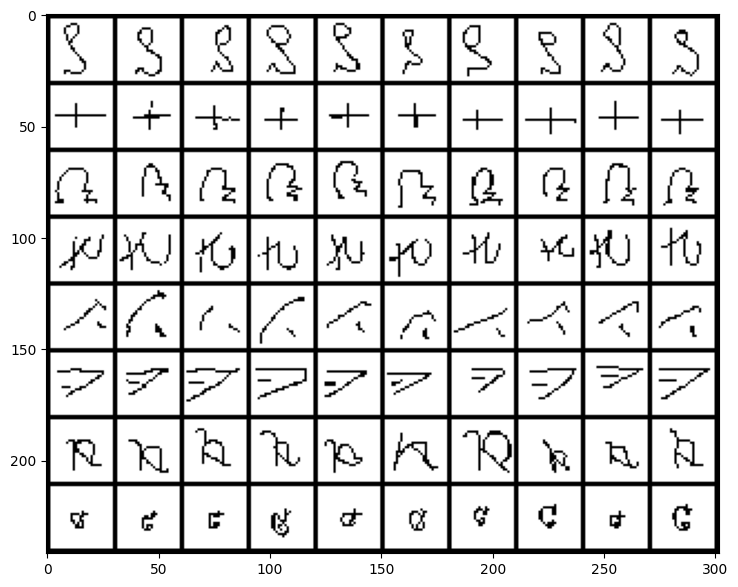

In [35]:
sample_example = gather_samples(8, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [36]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

##Build model

Paper: [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

The component responsible for embedding transforms an image of dimensions 28x28x3 into a vector with 64 elements. This transformation is achieved through a sequence of four stages, each featuring a convolutional layer with 64 filters of size 3x3, followed by batch normalization, a ReLU activation function, and a 2x2 max-pooling layer.

Utilizing this framework on the Omniglot dataset's 28x28 images, the model produces an output space with 64 dimensions.

In [38]:
class Simplify(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_tensor):
        return input_tensor.reshape(input_tensor.shape[0], -1)

def initialize_protonet(**params):
    input_dim = params['x_dim']
    hidden_dim = params['hid_dim']
    output_dim = params['z_dim']

    def build_block(input_channels, output_channels):
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

    model_encoder = nn.Sequential(
        build_block(input_dim[0], hidden_dim),
        build_block(hidden_dim, hidden_dim),
        build_block(hidden_dim, hidden_dim),
        build_block(hidden_dim, output_dim),
        Simplify()
    )

    return PrototypeNetwork(model_encoder)


In [44]:
# Corrected and optimized `calculate_loss` method in `PrototypeNetwork` class
class PrototypeNetwork(nn.Module):
    def __init__(self, model_encoder):
        super().__init__()
        self.encoder = model_encoder.to(device)

    def calculate_loss(self, batch):
        images = batch['images'].to(device)
        class_count = batch['n_way']
        support_size = batch['n_support']
        query_size = batch['n_query']

        support_images = images[:, :support_size].contiguous().view(class_count * support_size, *images.size()[2:])
        query_images = images[:, support_size:].contiguous().view(class_count * query_size, *images.size()[2:])

        target_indices = torch.arange(0, class_count).view(class_count, 1, 1).expand(class_count, query_size, 1).long().to(device)

        encoded_images = torch.cat([support_images, query_images], 0)
        encoded_vectors = self.encoder(encoded_images)
        prototype_vectors = encoded_vectors[:class_count*support_size].view(class_count, support_size, -1).mean(1)
        query_vectors = encoded_vectors[class_count*support_size:]

        distance = euclidean_dist(query_vectors, prototype_vectors)
        probability_log = F.log_softmax(-distance, dim=1).view(class_count, query_size, -1)
        loss = -probability_log.gather(2, target_indices).squeeze().view(-1).mean()
        prediction = probability_log.max(2)[1]
        accuracy = torch.eq(prediction, target_indices.squeeze()).float().mean()

        return loss, {'loss': loss.item(), 'accuracy': accuracy.item(), 'prediction': prediction}


In [45]:
def euclidean_dist(x, y):

  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

##Train

In [46]:
def train(proto_net, optimizer, images_train, labels_train, class_num, support_num, query_num, total_epochs, batch_count):
    lr_adjuster = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

    for current_epoch in range(total_epochs):
        cumulative_loss = 0.0
        cumulative_accuracy = 0.0

        for batch in trange(batch_count, desc=f"Training Epoch {current_epoch+1}"):
            batch_data = gather_samples(class_num, support_num, query_num, images_train, labels_train)
            optimizer.zero_grad()
            loss_value, metrics = proto_net.calculate_loss(batch_data)
            cumulative_loss += metrics['loss']
            cumulative_accuracy += metrics['accuracy']
            loss_value.backward()
            optimizer.step()

        average_loss = cumulative_loss / batch_count
        average_accuracy = cumulative_accuracy / batch_count
        print(f"Epoch {current_epoch+1} - Avg Loss: {average_loss:.4f}, Avg Accuracy: {average_accuracy:.4f}")

        lr_adjuster.step()


In [47]:
torch.cuda.is_available()

True

In [48]:
%%time

model = initialize_protonet(
    x_dim=(3,28,28),
    hid_dim=64,
    z_dim=64,
    )

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 60
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 2000

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

Training Epoch 1: 100%|██████████| 2000/2000 [03:01<00:00, 11.03it/s]


Epoch 1 - Avg Loss: 0.1141, Avg Accuracy: 0.9646


Training Epoch 2: 100%|██████████| 2000/2000 [03:00<00:00, 11.11it/s]


Epoch 2 - Avg Loss: 0.0457, Avg Accuracy: 0.9838


Training Epoch 3: 100%|██████████| 2000/2000 [03:07<00:00, 10.65it/s]


Epoch 3 - Avg Loss: 0.0337, Avg Accuracy: 0.9874


Training Epoch 4: 100%|██████████| 2000/2000 [03:01<00:00, 11.05it/s]


Epoch 4 - Avg Loss: 0.0293, Avg Accuracy: 0.9888


Training Epoch 5: 100%|██████████| 2000/2000 [03:02<00:00, 10.95it/s]

Epoch 5 - Avg Loss: 0.0263, Avg Accuracy: 0.9898
CPU times: user 15min 5s, sys: 3.98 s, total: 15min 9s
Wall time: 15min 12s


##Test

In [51]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    running_loss = 0.0
    running_accuracy = 0.0  # Updated variable name for clarity
    for episode in trange(test_episode):
        sample = gather_samples(n_way, n_support, n_query, test_x, test_y)
        loss, output = model.calculate_loss(sample)
        running_loss += output['loss']
        running_accuracy += output['accuracy']  # Updated key to match 'calculate_loss' output
    avg_loss = running_loss / test_episode
    avg_accuracy = running_accuracy / test_episode  # Use the updated variable name
    print(f'Test results -- Loss: {avg_loss:.4f} Acc: {avg_accuracy:.4f}')


In [52]:
n_way = 5
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

100%|██████████| 1000/1000 [00:29<00:00, 34.07it/s]

Test results -- Loss: 0.0192 Acc: 0.9962
